检查valid函数的正确性

In [ ]:
from rlepose.trainer import train, validate, validate_gt, validate_gt_3d

from rlepose.utils.transforms import get_coord

import rlepose.datasets.lxd_freihand as lxd_freihand
from rlepose.models import builder
from rlepose.utils.config import update_config

import torch
cfg = update_config("./configs/256x192_res50_regress-flow_freihand.yaml")

def preset_model(cfg):
    model = builder.build_sppe(cfg.MODEL, preset_cfg=cfg.DATA_PRESET)

    if cfg.MODEL.PRETRAINED:
        model.load_state_dict(torch.load(cfg.MODEL.PRETRAINED))
    elif cfg.MODEL.TRY_LOAD:
        pretrained_state = torch.load(cfg.MODEL.TRY_LOAD)
        model_state = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items()
                            if k in model_state and v.size() == model_state[k].size()}

        model_state.update(pretrained_state)
        model.load_state_dict(model_state)
    else:
        model._initialize()

    return model

m = preset_model(cfg)
m.train()

hm_shape = cfg.DATA_PRESET.get('HEATMAP_SIZE')
depth_dim = cfg.MODEL.get('DEPTH_DIM')
output_3d = cfg.DATA_PRESET.get('OUT_3D', False)
hm_shape = (hm_shape[1], hm_shape[0], depth_dim)
grad_clip = cfg.TRAIN.get('GRAD_CLIP', False)



heatmap_to_coord = get_coord(cfg, cfg.DATA_PRESET.HEATMAP_SIZE, output_3d)

gt_val_dataset = builder.build_dataset(cfg.DATASET.VAL, preset_cfg=cfg.DATA_PRESET, train=False, heatmap2coord=cfg.TEST.HEATMAP2COORD)
gt_val_sampler = torch.utils.data.distributed.DistributedSampler(
    gt_val_dataset, num_replicas=cfg.TRAIN.WORLD_SIZE, rank=1)

gt_val_loader = torch.utils.data.DataLoader(
    gt_val_dataset, batch_size=32, shuffle=False, num_workers=20, drop_last=False, sampler=gt_val_sampler)


# gt_AP = validate_gt(m, opt, cfg, heatmap_to_coord)


In [ ]:
for inps, labels in gt_val_loader:
    bboxes = labels.pop('bbox')
    raise

测试valid

In [ ]:
import torch
import cv2
import numpy as np
import torch
from rlepose.models import builder
from rlepose.utils.config import update_config
from sklearn.metrics import mean_squared_error
from rlepose.utils.valid_utils_lxd import calculate_error_distance_avg, calculate_RMSE, calculate_PCK, paint


cfg = update_config("./configs/256x192_res50_regress-flow_freihand.yaml")
device = torch.device('cuda')
m = builder.build_sppe(cfg.MODEL, preset_cfg=cfg.DATA_PRESET)  # 根据cfg的配置信息构建模型

m.load_state_dict(torch.load("/home/louxd/ldlib/res-loglikelihood-regression-master/weights/model_0918_233.pth", map_location='cpu'), 
                  strict=True)  # 加载权重

m.cuda(device)  # 把模型放到gpu中

with torch.no_grad():
    gt_val_dataset = builder.build_dataset(cfg.DATASET.VAL, preset_cfg=cfg.DATA_PRESET, train=False, heatmap2coord=cfg.TEST.HEATMAP2COORD)
    gt_val_sampler = torch.utils.data.distributed.DistributedSampler(
        gt_val_dataset, num_replicas=1, rank=0)

    gt_val_loader = torch.utils.data.DataLoader(
        gt_val_dataset, batch_size=16, shuffle=False, num_workers=20, drop_last=False, sampler=gt_val_sampler)
    
    
    rmse_list = []
    pck_pix = []
    pck_norm = []
    err_pix = []

    for index, (inps, labels) in enumerate(gt_val_loader):
        inps = inps.cuda(device)
        for k, _ in labels.items():
            if k == 'type':
                continue
            
            labels[k] = labels[k].cuda(device)

        # output = m(inps, labels)
        output = m(inps)

        if isinstance(inps, list):
            batch_size = inps[0].size(0)
        else:
            batch_size = inps.size(0)

        kpts_gt = labels['target_uv'].cpu().numpy().reshape(-1, 21, 2) # size * 42
        kpts_pre = output.pred_jts.cpu().numpy().reshape(-1, 21, 2)

        # print & draw
        for i in range(len(inps)):
            #print(f'batch:{batch_idx}_{i}')
            imgi = inps[i].cpu().numpy()
            imgi = np.transpose(imgi, (1, 2, 0))
            imgi = (imgi + np.array([0.480, 0.457, 0.406], dtype=np.float32)) * np.array([255., 255., 255.], dtype=np.float32)
            imgi = cv2.cvtColor(imgi, cv2.COLOR_BGR2RGB) 
            img_h, img_w, _ = imgi.shape
            kpts_pre_i = np.array([(kpt + [0.5, 0.5]) * [img_w, img_h] for kpt in kpts_pre[i]])
            kpts_gt_i = np.array([(kpt + [0.5, 0.5]) * [img_w, img_h] for kpt in kpts_gt[i]])


            # cal mAP and rmse
            # rmsei = compute_RMSE(kpts_pre_i, kpts_gt_i)
            mse_i = mean_squared_error(kpts_pre_i, kpts_gt_i)
            rmse_i = np.sqrt(mse_i)
            # oksi = calculate_oks_pt2(kpts_pre_i, kpts_gt_i)
            pck_pix_i, pck_norm_i = calculate_PCK(kpts_pre_i, kpts_gt_i)
            err_pix_i = calculate_error_distance_avg(kpts_pre_i, kpts_gt_i)
            rmse_list.append(rmse_i)
            pck_pix.append(pck_pix_i)
            pck_norm.append(pck_norm_i)
            err_pix.append(err_pix_i)

            # imagei_pre = imgi.copy()
            # imagei_gt = imgi.copy()
            # imagei_pre = paint(imagei_pre, kpts_pre_i)
            # imagei_gt = paint(imagei_gt, kpts_gt_i)
            # cv2.imwrite(f'./exp/output/{index}_{i}_pre.jpg', imagei_pre)
            # cv2.imwrite(f'./exp/output/{index}_{i}_gt.jpg', imagei_gt)


    rmse = sum(rmse_list) / len(rmse_list)
    pck_pix = np.mean(pck_pix, axis=0)
    pck_norm = np.mean(pck_norm, axis=0)
    err_pix = np.mean(err_pix)
    # mAP_info_str = calculate_mAP(oks_list)

    # ap = mAP_info_str['mAP']




In [ ]:
pck_pix

In [ ]:
from rlepose.utils.valid_utils_lxd import calculate_error_distance_avg, calculate_RMSE
def calculate_PCK(kpts_pred, kpts_true):
    assert kpts_pred.shape == kpts_true.shape, "Keypoints shape mismatch"
    max_x = np.max(kpts_true[:, 0])
    min_x = np.min(kpts_true[:, 0])
    max_y = np.max(kpts_true[:, 1])
    min_y = np.min(kpts_true[:, 1])
    norm = np.max([int(max_x - min_x), int(max_y - min_y)])
    num_joints = kpts_pred.shape[0]
    error_distance = np.sqrt(np.sum((kpts_pred - kpts_true) ** 2, axis=1))
    norm_distance = error_distance / norm

    pixel_thresholds = np.arange(0, 30, 1)
    norm_thresholds = np.arange(0, 1, 0.05)

    pixel_correct = np.zeros(len(pixel_thresholds))
    norm_correct = np.zeros(len(norm_thresholds))

    for i, pixel_thresh in enumerate(pixel_thresholds):
        pixel_correct[i] = np.sum(error_distance <= pixel_thresh) / num_joints

    for i, norm_thresh in enumerate(norm_thresholds):
        norm_correct[i] = np.sum(norm_distance <= norm_thresh) / num_joints

    
    return pixel_correct, norm_correct

测试mAP计算模型

In [5]:
import torch
import cv2
import numpy as np
import torch
from rlepose.models import builder
from rlepose.utils.config import update_config
from sklearn.metrics import mean_squared_error
from rlepose.utils.valid_utils_lxd import calculate_error_distance_avg, calculate_RMSE, calculate_PCK

cfg = update_config("./configs/256x192_res50_regress-flow_freihand.yaml")
device = torch.device('cuda')
m = builder.build_sppe(cfg.MODEL, preset_cfg=cfg.DATA_PRESET)  # 根据cfg的配置信息构建模型

m.load_state_dict(torch.load("/home/louxd/ldlib/res-loglikelihood-regression-master/weights/model_0919_355.pth", map_location='cpu'), 
                  strict=True)  # 加载权重

m.cuda(device)  # 把模型放到gpu中

with torch.no_grad():
    gt_val_dataset = builder.build_dataset(cfg.DATASET.VAL, preset_cfg=cfg.DATA_PRESET, train=False, heatmap2coord=cfg.TEST.HEATMAP2COORD)
    gt_val_sampler = torch.utils.data.distributed.DistributedSampler(
        gt_val_dataset, num_replicas=1, rank=0)

    gt_val_loader = torch.utils.data.DataLoader(
        gt_val_dataset, batch_size=16, shuffle=False, num_workers=20, drop_last=False, sampler=gt_val_sampler)
    
    
    rmse_list = []
    pck_pix = []
    pck_norm = []
    err_pix = []

    for index, (inps, labels) in enumerate(gt_val_loader):
        inps = inps.cuda(device)
        for k, _ in labels.items():
            if k == 'type':
                continue
            
            labels[k] = labels[k].cuda(device)

        # output = m(inps, labels)
        output = m(inps)

        if isinstance(inps, list):
            batch_size = inps[0].size(0)
        else:
            batch_size = inps.size(0)

        kpts_gt = labels['target_uv'].cpu().numpy().reshape(-1, 21, 2) # size * 42
        kpts_pre = output.pred_jts.cpu().numpy().reshape(-1, 21, 2)

        # print & draw
        for i in range(len(inps)):
            #print(f'batch:{batch_idx}_{i}')
            imgi = inps[i].cpu().numpy()
            imgi = np.transpose(imgi, (1, 2, 0))
            imgi = (imgi + np.array([0.480, 0.457, 0.406], dtype=np.float32)) * np.array([255., 255., 255.], dtype=np.float32)
            imgi = cv2.cvtColor(imgi, cv2.COLOR_BGR2RGB) 
            img_h, img_w, _ = imgi.shape
            kpts_pre_i = np.array([(kpt + [0.5, 0.5]) * [img_w, img_h] for kpt in kpts_pre[i]])
            kpts_gt_i = np.array([(kpt + [0.5, 0.5]) * [img_w, img_h] for kpt in kpts_gt[i]])


            # cal mAP and rmse
            # rmsei = compute_RMSE(kpts_pre_i, kpts_gt_i)
            _, rmse_i = calculate_RMSE(kpts_pre_i, kpts_gt_i)
            # oksi = calculate_oks_pt2(kpts_pre_i, kpts_gt_i)
            pck_pix_i, pck_norm_i = calculate_PCK(kpts_pre_i, kpts_gt_i)
            err_pix_i = calculate_error_distance_avg(kpts_pre_i, kpts_gt_i)
            rmse_list.append(rmse_i)
            pck_pix.append(pck_pix_i)
            pck_norm.append(pck_norm_i)
            err_pix.append(err_pix_i)

            # imagei_pre = imgi.copy()
            # imagei_gt = imgi.copy()
            # imagei_pre = paint(imagei_pre, kpts_pre_i)
            # imagei_gt = paint(imagei_gt, kpts_gt_i)
            # cv2.imwrite(f'./exp/output/{index}_{i}_pre.jpg', imagei_pre)
            # cv2.imwrite(f'./exp/output/{index}_{i}_gt.jpg', imagei_gt)


    rmse = np.mean(rmse_list, axis=0)
    pck_pix = np.mean(pck_pix, axis=0)
    pck_norm = np.mean(pck_norm, axis=0)
    err_pix = np.mean(err_pix)

print("Pixels PCK: ", pck_pix)
print("Norm PCK: ", pck_norm)
print("RMSE: ", rmse)
print("ERROR DISTANCE: ", err_pix)
    # mAP_info_str = calculate_mAP(oks_list)

    # ap = mAP_info_str['mAP']




anno_xyz len： 3960
anno_K len： 3960
img list len： 3960
AUG OFF.
Pixels PCK:  [0.         0.01726792 0.06653439 0.13796296 0.21880712 0.30238095
 0.38057961 0.4535594  0.51838624 0.5726912  0.62107985 0.66088264
 0.69613997 0.72693603 0.7533189  0.77498797 0.79559885 0.81227754
 0.82741703 0.84083694 0.85357143 0.86450216 0.87406205 0.88215488
 0.89010342 0.89694565 0.90324675 0.90918711 0.91441799 0.91958874]
Norm PCK:  [0.         0.55295815 0.81607744 0.90204425 0.94111352 0.96212121
 0.97560125 0.98382636 0.98887686 0.99208754 0.99487734 0.9965368
 0.99755892 0.9983165  0.9988456  0.99924242 0.99953102 0.99967532
 0.9998076  0.9998557 ]
RMSE:  46.6121900082357
ERROR DISTANCE:  11.942288036928371


绘制折线图


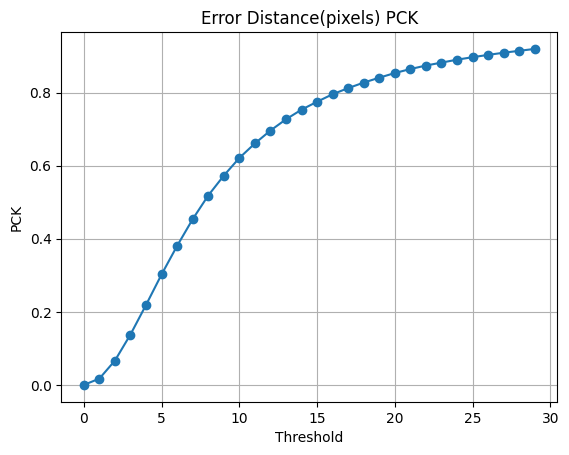

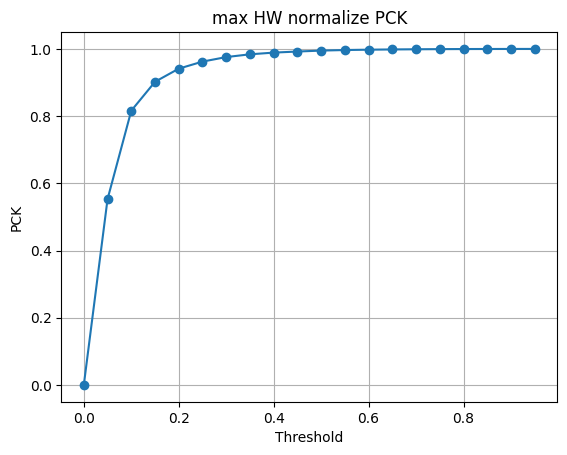

Pixels PCK:  [0.         0.01726792 0.06653439 0.13796296 0.21880712 0.30238095
 0.38057961 0.4535594  0.51838624 0.5726912  0.62107985 0.66088264
 0.69613997 0.72693603 0.7533189  0.77498797 0.79559885 0.81227754
 0.82741703 0.84083694 0.85357143 0.86450216 0.87406205 0.88215488
 0.89010342 0.89694565 0.90324675 0.90918711 0.91441799 0.91958874]
Norm PCK:  [0.         0.55295815 0.81607744 0.90204425 0.94111352 0.96212121
 0.97560125 0.98382636 0.98887686 0.99208754 0.99487734 0.9965368
 0.99755892 0.9983165  0.9988456  0.99924242 0.99953102 0.99967532
 0.9998076  0.9998557 ]
RMSE:  46.6121900082357
ERROR DISTANCE:  11.942288036928371


In [6]:
import matplotlib.pyplot as plt
pixel_thresholds = np.arange(0, 30, 1)
norm_thresholds = np.arange(0, 1, 0.05)

average_precision = pck_pix

plt.plot(pixel_thresholds, average_precision, '-o')
plt.xlabel('Threshold')
plt.ylabel('PCK')
plt.title('Error Distance(pixels) PCK')
plt.grid(True)
plt.show()

norm_thresholds = np.arange(0, 1, 0.05)

average_precision = pck_norm


plt.plot(norm_thresholds, average_precision, '-o')
plt.xlabel('Threshold')
plt.ylabel('PCK')
plt.title('max HW normalize PCK')
plt.grid(True)
plt.show()

print("Pixels PCK: ", pck_pix)
print("Norm PCK: ", pck_norm)
print("RMSE: ", rmse)
print("ERROR DISTANCE: ", err_pix)

测试RLE\MEDIAPIPE\OURS的指标并进行对比

TypeError: 'float' object is not iterable

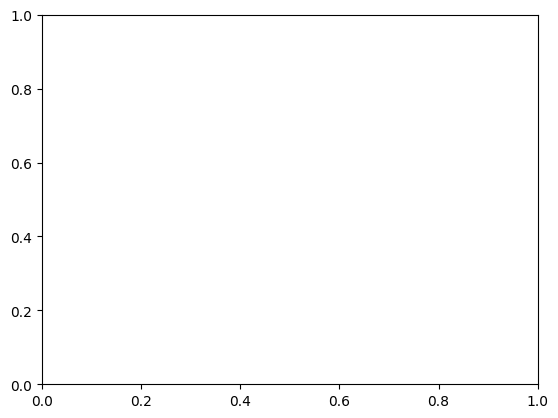

In [7]:
ours_Pixels_PCK = np.array([0., 0.01726792, 0.06653439, 0.13796296, 0.21880712, 0.30238095, 0.38057961, 0.4535594, 0.51838624, 0.5726912, 0.62107985, 0.66088264, 
                   0.69613997, 0.72693603, 0.7533189, 0.77498797, 0.79559885, 0.81227754, 0.82741703, 0.84083694, 0.85357143, 0.86450216, 0.87406205,
                    0.88215488, 0.89010342, 0.89694565, 0.90324675, 0.90918711, 0.91441799, 0.91958874])
ours_Norm_PCK = [0., 0.55295815, 0.81607744, 0.90204425, 0.94111352, 0.96212121,0.97560125, 0.98382636, 0.98887686, 0.99208754, 0.99487734, 0.9965368,
                 0.99755892, 0.9983165, 0.9988456, 0.99924242, 0.99953102, 0.99967532, 0.9998076, 0.9998557]

mdp_Pixels_PCK = [0., 0.00571429, 0.04095238, 0.08285714, 0.1352381, 0.19809524, 0.2552381, 0.32, 0.37142857, 0.42571429, 0.46952381, 0.51238095,
                  0.54857143, 0.58095238, 0.60095238, 0.61619048, 0.62761905, 0.64095238, 0.65142857, 0.66190476, 0.67142857, 0.67904762, 0.68761905, 0.69428571, 
                  0.70380952, 0.70952381, 0.71238095, 0.71904762, 0.72190476, 0.72571429]
mdp_Norm_PCK = [0., 0.36761905, 0.63142857, 0.69714286, 0.73238095, 0.75904762, 0.78285714, 0.80952381, 0.83428571, 0.85333333, 0.87238095, 0.89333333,
                0.91142857, 0.92857143, 0.94190476, 0.95428571, 0.96380952, 0.97333333, 0.97904762, 0.98571429]

rle_Pixels_PCK = [0., 0.0863539, 0.23493013, 0.36835368, 0.47308241, 0.55456621, 0.61749494, 0.66885388, 0.70885258, 0.74231127, 0.76963602, 0.79208422,
                  0.81127258, 0.82721736, 0.84130243, 0.85322904, 0.86465426, 0.87423361, 0.88288338, 0.89053915, 0.89698961, 0.90335377, 0.90917829, 0.91387573,
                  0.91857629, 0.9233544, 0.9268849, 0.93059859, 0.9339393, 0.93636656]
rle_Norm_PCK = [0., 0.67507158, 0.82697485, 0.88128352, 0.90845754, 0.92444002, 0.93576903, 0.94318301, 0.94833947, 0.95263585, 0.95660906, 0.95961432, 
                0.96191039, 0.96344733, 0.96482638, 0.96660241, 0.9679145, 0.96896552, 0.97023152, 0.9709191]

import matplotlib.pyplot as plt
pixel_thresholds = np.arange(0, 30, 1)
norm_thresholds = np.arange(0, 1, 0.05)

fig, ax = plt.subplots()

ax.scatter(*zip(*ours_Pixels_PCK), color='green', label='a')
ax.scatter(*zip(*mdp_Pixels_PCK), color='red', label='b')
ax.scatter(*zip(*rle_Pixels_PCK), color='blue', label='c')
ax.legend()
plt.xlabel('Threshold')
plt.ylabel('PCK')
plt.title('Error Distance(pixels) PCK')
plt.grid(True)
plt.show()

norm_thresholds = np.arange(0, 1, 0.05)

average_precision = pck_norm


